### Introducción
 ##### La ciencia de datos juega un papel preponderante y en crecimiento en cuanto al análisis y predicciones de los resultados de los eventos deportivos. Estos se usa principalmente en el fútbol europeo donde casi todos los equipos y selecciones del continente, tienen departamentos de datos dedicados a identificar jugadores, estudiar lesiones y el reclutamiento de nuevos talentos. También, se ve mucha aplicación en el básquet y béisbol en EE.UU. por lo mismos motivos. 

 ##### En el mundo de tenis, los datos están presentes como algo descriptivo del juego y que, hace años, está presente en las transmiciones de TV como en las páginas web del circuito profesional. Actualmente, la data de los partidos se usa mucho para las casas de apuestas para determinar las probabilidades del ganador del partido. No se usa mucho para el desarrollo del club o equipo como se usa en el fútbol, todavía es algo "verde". 
 
 ##### Cómo amante del tenis, busco crear un modelo que me permita saber de antemano, cuál es el jugador que tiene mas chances de ganar un partido.
 
 ##### En nuestro caso, busco hacer una análisis completo de cada perfil de jugador y entender cuáles son los mejores match-ups y que probabilidades tienen de ganar.

In [55]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance

In [2]:
df_truncated_2 = pd.read_csv('atp_matches_2004_2022_w_l.csv')


Data description

• tourney_id - tournament_id

• tourney_name - tournament_name

• surface - surface in which the match is played

• draw_size - the size of the draw

• tourney_level - tournament level

'G' = Grand Slams

'M' = Masters 1000s

'A' = other tour-level events

'C' = Challengers

'S' = Satellites/ITFs

'F' = Tour finals and other season-ending events

'D' = Davis Cup

• tourney_date - starting date of the tournament

• match num - match number in a certain tournament

• id - player id

• seed - the seed of the player in that tournament

• entry - How did the player enter the tournaments?

WC - Wildcard

Q - Qualifier

LL - Lucky loser

PR - Protected ranking

SE - Special Exempt

ALT - Alternate player

• name - player name

• hand - hand of the player, right or left

• ht - the height of the player

• IOC - the country of origin

• age - age of the player

• score - final score in the match

• best_of - the maximum number of sets played

• round - the round in the tournament a match belongs to

• minutes - duration of the match in minutes

• ace - number of aces in the match
• df - double faults

• svpt - serve percent

• 1stin - first serve in percent

• 1stWon - first serve winning percent

• 2ndWon - second serve winning percent

• SvGms - number of games played on serve (So, the maximum difference between w_SvGms and l_SvGms will be 1)

• bpSaved - breakpoints saved

• bpFaced - breakpoints faced


In [3]:
df_truncated_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50996 entries, 0 to 50995
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          50996 non-null  int64 
 1   tourney_id          50996 non-null  object
 2   tourney_name        50996 non-null  object
 3   surface             50996 non-null  object
 4   draw_size           50996 non-null  int64 
 5   tourney_level       50996 non-null  object
 6   tourney_date        50996 non-null  int64 
 7   match_num           50996 non-null  int64 
 8   winner_id           50996 non-null  int64 
 9   winner_seed         50996 non-null  int64 
 10  winner_entry        50996 non-null  object
 11  winner_name         50996 non-null  object
 12  winner_hand         50996 non-null  object
 13  winner_ht           50996 non-null  int64 
 14  winner_ioc          50996 non-null  object
 15  winner_age          50996 non-null  int64 
 16  loser_id            50

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
pd.set_option('display.max_rows', None)

#### Para el caso de este análisis preliminar, haremos un breve EDA con un jugador conocido: Novak Djokovic.

#### Usaremos un dataset ya modificado en entragas anteriores, con el data wrangling ya hecho.

#### Tomaremos los partidos donde Novak haya jugado. Buscamos tanto del lado del ganador como perdedor.

In [66]:
df_novak_1 = df_truncated_2[df_truncated_2['winner_name'] == 'Novak Djokovic']
df_novak_1['target'] = 1
df_nadal_1 = df_truncated_2[df_truncated_2['winner_name'] == 'Rafael Nadal']
df_nadal_1['target'] = 0

C:\Users\Usuario\AppData\Local\Temp\ipykernel_21668\2474023485.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_novak_1['target'] = 1
C:\Users\Usuario\AppData\Local\Temp\ipykernel_21668\2474023485.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nadal_1['target'] = 0


In [67]:
df_novak_1.shape
df_nadal_1.shape

(1028, 51)

In [8]:
df_novak_1.sample(10)

,Unnamed: 0,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,target
5887,139081,2006-2276,Zagreb,Carpet,32,A,20060130,19,104925,0,0,Novak Djokovic,R,188,SRB,18,103285,4,0,Radek Stepanek,R,185,CZE,27,6-3 6-4,3,R16,83,7,3,60,33,26,15,10,1,2,4,2,53,34,22,9,9,4,7,81,487,21,1400,1
37469,174156,2017-M016,Eastbourne,Grass,32,A,20170626,300,104925,1,0,Novak Djokovic,R,188,SRB,30,104792,2,0,Gael Monfils,R,193,FRA,30,6-3 6-4,3,F,76,1,1,58,42,32,8,9,3,3,6,1,63,45,30,7,10,3,6,4,5805,16,2545,1
34087,170734,2016-M021,Madrid Masters,Clay,64,M,20160502,299,104925,1,0,Novak Djokovic,R,188,SRB,28,105453,6,0,Kei Nishikori,R,178,JPN,26,6-3 7-6(4),3,SF,118,4,2,79,58,44,9,11,4,5,1,2,80,49,34,14,10,5,7,1,15550,6,4290,1
40272,176990,2018-0311,Queen's Club,Grass,32,A,20180618,286,104925,0,WC,Novak Djokovic,R,188,SRB,31,105777,2,0,Grigor Dimitrov,R,188,BUL,27,6-4 6-1,3,R16,65,3,4,52,34,30,10,9,1,1,8,5,48,26,16,11,8,3,6,22,1665,5,4870,1
21670,156915,2011-421,Canada Masters,Hard,56,M,20110808,41,104925,1,0,Novak Djokovic,R,188,SRB,24,105227,0,0,Marin Cilic,R,198,CRO,22,7-5 6-2,3,R16,95,1,1,66,48,37,9,10,3,3,6,4,57,34,21,14,10,4,7,1,12860,29,1295,1
16059,150368,2009-5014,Shanghai Masters,Hard,56,M,20091011,40,104925,2,0,Novak Djokovic,R,188,SRB,22,104926,0,Q,Fabio Fognini,R,178,ITA,22,6-3 6-1,3,R32,70,3,1,50,29,24,10,8,3,4,2,2,50,39,21,2,8,2,7,4,7740,66,720,1
11756,145693,2008-311,Queen's Club,Grass,56,A,20080609,52,104925,2,0,Novak Djokovic,R,188,SRB,21,103720,11,0,Lleyton Hewitt,R,180,AUS,27,6-2 6-2,3,QF,72,13,2,62,48,34,7,8,3,3,4,2,57,33,22,8,8,2,6,3,5225,30,1010,1
5192,138045,2005-540,Wimbledon,Grass,128,G,20050620,91,104925,0,Q,Novak Djokovic,R,188,SRB,18,104198,0,0,Guillermo Garcia Lopez,R,188,ESP,22,3-6 3-6 7-6(5) 7-6(3) 6-4,5,R64,248,8,4,173,105,75,31,26,9,18,6,5,182,108,76,33,26,10,17,128,337,81,513,1
9283,142836,2007-337,Vienna,Hard,32,A,20071007,1,104925,1,0,Novak Djokovic,R,188,SRB,20,104068,0,0,Robby Ginepri,R,183,USA,25,6-3 6-4,3,R32,77,5,3,55,34,22,12,10,0,3,5,0,54,35,21,5,9,4,9,3,4145,70,535,1
36827,173510,2017-0410,Monte Carlo Masters,Clay,64,M,20170417,270,104925,2,0,Novak Djokovic,R,188,SRB,29,104468,0,0,Gilles Simon,R,183,FRA,32,6-3 3-6 7-5,3,R32,0,2,1,83,51,32,19,15,1,6,0,1,93,52,31,20,15,10,16,2,7905,32,1255,1


In [68]:
df_nadal_1.sample(10)

,Unnamed: 0,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,target
12800,146747,2008-421,Canada Masters,Hard,56,M,20080721,48,104745,2,0,Rafael Nadal,L,185,ESP,22,104214,0,0,Igor Andreev,R,185,RUS,25,6-2 7-6(1),3,R16,111,4,2,54,42,36,8,10,0,0,1,0,79,50,32,15,10,7,9,2,5830,26,1065,0
32191,168748,2015-421,Canada Masters,Hard,56,M,20150810,45,104745,7,0,Rafael Nadal,L,185,ESP,29,104022,0,Q,Mikhail Youzhny,R,183,RUS,33,6-3 6-3,3,R16,0,2,2,63,46,34,8,9,3,3,2,5,73,42,26,15,9,7,10,9,3500,107,505,0
16531,150841,2009-560,US Open,Hard,128,G,20090831,88,104745,3,0,Rafael Nadal,L,185,ESP,23,103017,0,0,Nicolas Kiefer,R,183,GER,32,6-0 3-6 6-3 6-4,5,R64,179,3,1,82,51,37,26,17,1,3,7,5,133,54,38,33,17,9,15,3,9025,129,500,0
38876,175581,2018-580,Australian Open,Hard,128,G,20180115,301,104745,1,0,Rafael Nadal,L,185,ESP,31,106000,28,0,Damir Dzumhur,R,172,BIH,25,6-1 6-3 6-1,5,R32,110,4,0,79,51,34,19,12,1,2,5,6,75,40,22,11,11,9,16,1,10600,30,1391,0
11292,144858,2007-605,Masters Cup,Hard,8,F,20071112,1,104745,0,0,Rafael Nadal,L,185,ESP,21,104755,0,0,Richard Gasquet,R,185,FRA,21,3-6 6-3 6-4,3,RR,126,5,1,75,52,39,12,14,2,4,12,3,91,58,43,14,14,3,6,2,5535,8,1830,0
7246,140446,2006-421,Canada Masters,Hard,64,M,20060807,32,104745,2,0,Rafael Nadal,L,185,ESP,20,103454,0,0,Nicolas Massu,R,183,CHI,26,6-3 6-2,3,R64,109,0,1,61,33,23,16,8,7,8,4,5,64,32,23,8,9,1,6,2,4930,38,900,0
19200,154115,2010-560,US Open,Hard,128,G,20100830,127,104745,1,0,Rafael Nadal,L,185,ESP,24,104925,3,0,Novak Djokovic,R,188,SRB,23,6-4 5-7 6-4 6-2,5,F,223,8,2,112,75,55,21,20,1,4,5,4,143,94,61,22,20,20,25,1,10745,3,6665,0
31636,168084,2015-321,Stuttgart,Grass,28,A,20150608,21,104745,1,0,Rafael Nadal,L,185,ESP,29,106071,5,0,Bernard Tomic,R,193,AUS,22,6-4 6-7(6) 6-3,3,QF,0,14,5,110,75,60,16,16,8,9,14,0,94,66,51,12,15,3,6,10,2930,24,1355,0
38320,175010,2017-M015,Beijing,Hard,32,A,20171002,285,104745,1,0,Rafael Nadal,L,185,ESP,31,106298,0,0,Lucas Pouille,R,185,FRA,23,4-6 7-6(6) 7-5,3,R32,151,4,7,102,73,59,15,17,3,4,9,5,110,65,50,21,17,3,4,1,9465,23,1825,0
16160,150469,2009-520,Roland Garros,Clay,128,G,20090525,1,104745,1,0,Rafael Nadal,L,185,ESP,22,103228,0,Q,Marcos Daniel,R,180,BRA,30,7-5 6-4 6-3,5,R128,143,3,0,82,62,42,13,15,4,7,4,1,93,52,32,17,16,4,11,1,14960,97,798,0


In [79]:
df_novak_2 = df_truncated_2[df_truncated_2['loser_name'] == 'Novak Djokovic']
df_novak_2['target'] = 0
df_nadal_2 = df_truncated_2[df_truncated_2['loser_name'] == 'Rafael Nadal']

C:\Users\Usuario\AppData\Local\Temp\ipykernel_21668\609070277.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_novak_2['target'] = 0


In [10]:
df_novak_2.shape

(193, 51)

In [80]:
df_nadal_2.shape

(202, 50)

In [11]:
df_novak_2.sample(10)

,Unnamed: 0,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,target
30847,167160,2015-495,Dubai,Hard,32,A,20150223,31,103819,2,0,Roger Federer,R,185,SUI,33,104925,1,0,Novak Djokovic,R,188,SRB,27,6-3 7-5,3,F,84,12,1,79,51,41,11,11,7,7,1,2,62,39,27,12,10,0,2,2,9205,1,13045,0
49610,186611,2022-520,Roland Garros,Clay,128,G,20220523,220,104745,5,0,Rafael Nadal,L,185,ESP,35,104925,1,0,Novak Djokovic,R,188,SRB,35,6-2 4-6 6-2 7-6(4),5,QF,252,3,4,138,99,64,24,19,8,12,5,4,140,97,62,18,19,10,17,5,5525,1,8660,0
6758,139958,2006-403,Miami Masters,Hard,96,M,20060320,48,103909,7,0,Guillermo Coria,R,175,ARG,24,104925,0,0,Novak Djokovic,R,188,SRB,18,7-5 6-1,3,R64,88,1,0,52,39,24,10,9,0,2,2,6,82,43,24,15,10,12,18,7,2025,66,596,0
3636,136479,2005-352,Paris Masters,Carpet,48,M,20051031,35,103990,14,0,Tommy Robredo,R,180,ESP,23,104925,0,Q,Novak Djokovic,R,188,SRB,18,6-4 6-3,3,R16,81,6,3,57,33,27,11,9,3,4,4,3,78,41,27,15,10,9,13,21,1370,85,488,0
53,132486,2004-1720,Bangkok,Hard,32,A,20040927,7,102615,0,0,Dennis Van Scheppingen,R,185,NED,29,104925,0,WC,Novak Djokovic,R,188,SRB,17,4-6 7-5 6-4,3,R32,112,7,7,88,57,39,18,16,3,7,15,12,118,70,45,22,16,10,15,81,496,248,148,0
26185,162084,2013-416,Rome Masters,Clay,56,M,20130512,49,104607,6,0,Tomas Berdych,R,196,CZE,27,104925,1,0,Novak Djokovic,R,188,SRB,25,2-6 7-5 6-4,3,QF,142,9,3,106,67,53,14,15,3,6,8,1,90,62,43,15,15,2,5,6,4520,1,12730,0
29652,165883,2014-422,Cincinnati Masters,Hard,56,M,20140810,41,103990,16,0,Tommy Robredo,R,180,ESP,32,104925,1,0,Novak Djokovic,R,188,SRB,27,7-6(6) 7-5,3,R16,105,5,1,69,45,34,17,12,0,1,10,3,78,51,36,12,12,4,6,20,1735,1,12860,0
23077,158537,2012-404,Indian Wells Masters,Hard,96,M,20120308,93,104545,11,0,John Isner,R,206,USA,26,104925,1,0,Novak Djokovic,R,188,SRB,24,7-6(7) 3-6 7-6(5),3,SF,166,20,0,112,83,60,15,16,4,6,8,2,111,72,56,24,17,1,2,11,2120,1,13310,0
8745,142297,2007-1536,Madrid Masters,Hard,48,M,20071015,46,103900,0,0,David Nalbandian,R,180,ARG,25,104925,3,0,Novak Djokovic,R,188,SRB,20,6-4 7-6(4),3,SF,105,8,0,68,41,35,15,11,2,2,9,5,81,47,34,16,11,4,5,25,1160,3,4370,0
5211,138064,2005-540,Wimbledon,Grass,128,G,20050620,110,103206,9,0,Sebastien Grosjean,R,175,FRA,27,104925,0,Q,Novak Djokovic,R,188,SRB,18,7-5 6-4 5-7 6-4,5,R32,171,7,3,140,79,60,35,22,3,4,6,4,126,88,66,21,22,6,9,27,1215,128,337,0


#### Hacemos una descripción de los datos brindados de sus trinufos. El énfasis va a ser los campos w_ y l_ ya que indican los números del ganador (w_ > Novak Djokovic) contra los del perdedor (l_ > Rivales). Esto nos dará un detalle a priori, de los datos que son importantes a analizar.

In [12]:
df_novak_1.describe()

,Unnamed: 0,draw_size,tourney_date,match_num,winner_id,winner_seed,winner_ht,winner_age,loser_id,loser_seed,loser_ht,loser_age,best_of,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,target
count,998.000000,998.000000,9.980000e+02,998.000000,998.0,998.000000,998.0,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.0
mean,163344.118236,77.074148,2.013561e+07,143.706413,104925.0,2.205411,188.0,26.091182,107663.613226,4.171343,186.616232,26.537074,3.677355,108.625251,5.713427,2.152305,75.312625,49.055110,37.083166,14.997996,12.432866,3.022044,4.410822,4.971944,2.965932,80.500000,48.603206,31.398798,13.735471,12.008016,5.103206,9.421844,5.390782,9207.080160,50.835671,2096.990982,1.0
std,13639.722463,42.168127,4.647894e+04,172.387597,0.0,2.693819,0.0,4.691560,13640.920685,7.159432,10.775265,3.767587,0.946995,50.808724,3.821236,1.940657,29.089466,19.131807,13.640171,6.173844,4.290948,2.813407,3.662760,4.504229,2.102881,30.480201,19.871172,14.527989,7.190778,4.296897,3.338534,4.208865,15.753798,4206.847636,75.438465,2248.417335,0.0
min,135216.000000,2.000000,2.004091e+07,1.000000,104925.0,0.000000,188.0,17.000000,100644.000000,0.000000,0.000000,17.000000,3.000000,0.000000,0.000000,0.000000,12.000000,8.000000,6.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,16.000000,9.000000,3.000000,1.000000,3.000000,0.000000,1.000000,1.000000,128.000000,0.000000,0.000000,1.0
25%,151368.000000,32.000000,2.009337e+07,40.000000,104925.0,1.000000,188.0,22.000000,104028.250000,0.000000,183.000000,24.000000,3.000000,78.000000,3.000000,1.000000,55.000000,35.000000,27.000000,11.000000,9.000000,1.000000,2.000000,2.000000,2.000000,59.000000,34.000000,21.000000,9.000000,9.000000,3.000000,6.000000,1.000000,6405.000000,12.000000,749.250000,1.0
50%,163346.000000,64.000000,2.013093e+07,93.000000,104925.0,1.000000,188.0,26.000000,104731.000000,0.000000,185.000000,26.000000,3.000000,100.000000,5.000000,2.000000,69.000000,45.500000,35.000000,14.000000,11.000000,2.000000,4.000000,4.000000,3.000000,75.500000,46.000000,29.000000,12.000000,11.000000,5.000000,9.000000,2.000000,10220.000000,33.000000,1210.500000,1.0
75%,174152.000000,128.000000,2.017063e+07,225.000000,104925.0,3.000000,188.0,30.000000,105379.000000,6.000000,190.000000,29.000000,5.000000,134.000000,8.000000,3.000000,90.000000,58.000000,44.000000,18.000000,15.000000,4.000000,6.000000,7.000000,4.000000,94.750000,58.000000,38.000000,17.000000,14.000000,7.000000,12.000000,3.000000,12150.000000,65.000000,2443.750000,1.0
max,187952.000000,128.000000,2.022111e+07,1601.000000,104925.0,20.000000,188.0,35.000000,208029.000000,33.000000,208.000000,38.000000,5.000000,353.000000,26.000000,12.000000,219.000000,136.000000,102.000000,49.000000,34.000000,19.000000,24.000000,40.000000,15.000000,225.000000,150.000000,102.000000,58.000000,34.000000,19.000000,27.000000,272.000000,16950.000000,1543.000000,13130.000000,1.0


In [69]:
df_nadal_1.describe()

,Unnamed: 0,draw_size,tourney_date,match_num,winner_id,winner_seed,winner_ht,winner_age,loser_id,loser_seed,loser_ht,loser_age,best_of,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,target
count,1028.000000,1028.000000,1.028000e+03,1028.000000,1028.0,1028.000000,1028.0,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.0
mean,159207.707198,77.140078,2.012219e+07,130.250000,104745.0,2.416342,185.0,25.533074,107262.857977,4.106031,185.946498,26.040856,3.624514,113.770428,3.254864,1.611868,71.447471,48.587549,35.942607,13.521401,11.867704,3.022374,4.325875,5.142023,2.716926,77.364786,47.418288,30.186770,12.784047,11.678988,4.996109,9.407588,4.926070,7296.360895,55.678016,1766.391051,0.0
std,15054.420294,39.135246,5.084395e+04,183.705685,0.0,2.931514,0.0,5.077000,14133.044166,7.122481,9.058828,3.878923,0.927279,48.576943,2.760344,1.540791,27.194316,19.654591,13.532017,5.553539,4.058243,2.963012,3.836969,5.137569,2.120661,28.314381,19.322461,14.324999,6.407765,4.032254,3.309716,4.122069,9.980525,3443.659432,67.477043,1975.196049,0.0
min,132447.000000,4.000000,2.004011e+07,1.000000,104745.0,0.000000,185.0,17.000000,100644.000000,0.000000,0.000000,17.000000,3.000000,0.000000,0.000000,0.000000,9.000000,5.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,5.000000,4.000000,2.000000,0.000000,1.000000,0.000000,0.000000,1.000000,585.000000,1.000000,23.000000,0.0
25%,146573.000000,48.000000,2.008043e+07,36.000000,104745.0,1.000000,185.0,21.000000,103888.000000,0.000000,183.000000,23.000000,3.000000,82.000000,1.000000,0.000000,52.000000,34.000000,26.000000,10.000000,9.000000,1.000000,2.000000,2.000000,1.000000,57.000000,33.000000,20.000000,8.000000,9.000000,3.000000,6.000000,1.000000,4875.000000,15.750000,664.750000,0.0
50%,157964.000000,64.000000,2.012012e+07,64.000000,104745.0,2.000000,185.0,25.000000,104593.000000,0.000000,185.000000,26.000000,3.000000,107.500000,3.000000,1.000000,66.000000,45.000000,34.000000,13.000000,11.000000,2.000000,3.000000,4.000000,2.000000,72.000000,45.000000,28.000000,12.000000,11.000000,4.000000,9.000000,2.000000,6525.000000,37.000000,1075.000000,0.0
75%,172493.000000,128.000000,2.017011e+07,195.000000,104745.0,2.000000,185.0,30.000000,105224.000000,6.000000,190.000000,29.000000,5.000000,139.000000,5.000000,2.000000,86.000000,59.000000,43.000000,17.000000,14.000000,4.000000,6.000000,7.000000,4.000000,93.000000,57.000000,37.000000,16.000000,14.000000,7.000000,12.000000,4.000000,9670.000000,73.000000,1893.750000,0.0
max,187941.000000,128.000000,2.022111e+07,1701.000000,104745.0,32.000000,185.0,36.000000,208014.000000,33.000000,211.000000,39.000000,5.000000,324.000000,18.000000,11.000000,218.000000,160.000000,111.000000,35.000000,30.000000,16.000000,22.000000,35.000000,13.000000,212.000000,148.000000,104.000000,40.000000,30.000000,21.000000,29.000000,71.000000,15390.000000,694.000000,12670.000000,0.0


In [84]:
df_novak_1['w_1serve_per'] = ((df_novak_1['w_1stIn']/df_novak_1['w_svpt'])*100).astype(int)
df_nadal_1['w_1serve_per'] = ((df_nadal_1['w_1stIn']/df_nadal_1['w_svpt'])*100).astype(int)
df_novak_2['w_1serve_per'] = ((df_novak_2['w_1stIn']/df_novak_2['w_svpt'])*100).astype(int)
df_nadal_2['w_1serve_per'] = ((df_nadal_2['w_1stIn']/df_nadal_2['w_svpt'])*100).astype(int)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_21668\2027587026.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_novak_1['w_1serve_per'] = ((df_novak_1['w_1stIn']/df_novak_1['w_svpt'])*100).astype(int)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_21668\2027587026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nadal_1['w_1serve_per'] = ((df_nadal_1['w_1stIn']/df_nadal_1['w_svpt'])*100).astype(int)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_21668\2027587026.py:3: SettingWithCopyWarning: 
A va

In [14]:
df_novak_1.sample(10)

,Unnamed: 0,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,target,w_1serve_per
42592,179340,2019-M009,Rome Masters,Clay,64,M,20190513,299,104925,1,0,Novak Djokovic,R,188,SRB,31,106043,0,0,Diego Schwartzman,R,170,ARG,26,6-3 6-7(2) 6-3,3,SF,151,2,1,99,65,45,21,16,2,4,0,2,80,50,33,19,14,1,5,1,12115,24,1440,1,65
16797,151110,2009-605,Tour Finals,Hard,8,F,20091122,14,104925,0,0,Novak Djokovic,R,188,SRB,22,104745,0,0,Rafael Nadal,L,185,ESP,23,7-6(5) 6-3,3,RR,118,2,3,73,37,29,19,11,4,6,4,1,71,55,33,8,10,2,5,3,7910,2,9205,1,50
15569,149873,2009-422,Cincinnati Masters,Hard,56,M,20090816,54,104925,4,0,Novak Djokovic,R,188,SRB,22,104745,2,0,Rafael Nadal,L,185,ESP,23,6-1 6-4,3,SF,92,5,1,55,36,27,11,9,1,1,1,3,56,35,21,10,8,3,6,4,7150,3,8665,1,65
45240,182093,2020-520,Roland Garros,Clay,128,G,20200928,1401,104925,1,0,Novak Djokovic,R,188,SRB,33,111575,15,0,Karen Khachanov,R,198,RUS,24,6-4 6-3 6-3,5,R16,143,2,1,89,57,40,19,14,7,9,5,4,111,77,42,16,14,9,15,1,11260,16,2200,1,64
34948,171601,2016-0421,Canada Masters,Hard,64,M,20160725,300,104925,1,0,Novak Djokovic,R,188,SRB,29,105453,3,0,Kei Nishikori,R,178,JPN,26,6-3 7-5,3,F,82,5,0,58,44,36,6,11,1,2,4,2,59,41,26,9,10,2,5,1,15040,6,4290,1,75
19620,154611,2010-328,Basel,Hard,32,A,20101101,30,104925,2,0,Novak Djokovic,R,188,SRB,23,104678,0,0,Viktor Troicki,R,193,SRB,24,7-6(4) 6-4,3,SF,98,3,2,68,37,28,19,11,2,3,8,1,67,40,32,13,11,3,5,3,7145,32,1225,1,54
41256,177980,2018-5014,Shanghai Masters,Hard,64,M,20181008,270,104925,2,0,Novak Djokovic,R,188,SRB,31,104871,0,0,Jeremy Chardy,R,188,FRA,31,6-3 7-5,3,R32,83,4,2,53,40,34,6,10,0,0,7,3,65,44,31,8,11,2,5,3,6445,41,1100,1,75
40461,177181,2018-540,Wimbledon,Grass,128,G,20180702,222,104925,12,0,Novak Djokovic,R,188,SRB,31,105453,24,0,Kei Nishikori,R,178,JPN,28,6-3 3-6 6-2 6-2,5,QF,155,6,3,91,61,52,12,17,4,7,3,1,117,80,47,16,17,7,14,21,1715,28,1530,1,67
32254,168811,2015-422,Cincinnati Masters,Hard,56,M,20150816,53,104925,1,0,Novak Djokovic,R,188,SRB,28,105238,0,Q,Alexandr Dolgopolov,R,180,UKR,26,4-6 7-6(5) 6-2,3,SF,0,8,6,103,62,40,24,15,5,8,6,6,88,42,29,23,15,1,5,1,14265,66,750,1,60
50933,187951,2022-0605,Tour Finals,Hard,8,F,20221114,287,104925,7,0,Novak Djokovic,R,188,SRB,35,106421,4,0,Daniil Medvedev,R,198,RUS,26,6-3 6-7(5) 7-6(2),3,RR,191,9,3,131,85,67,22,17,5,6,16,2,126,93,60,17,16,4,6,8,3320,5,4065,1,64


In [71]:
df_nadal_1.sample(10)

,Unnamed: 0,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,target,w_1serve_per
3830,136676,2005-403,Miami Masters,Hard,96,M,20050321,92,104745,29,0,Rafael Nadal,L,185,ESP,18,102563,25,0,Thomas Johansson,R,180,SWE,29,6-2 6-4,3,QF,84,1,2,48,33,25,9,9,0,1,2,3,61,34,22,10,9,5,9,31,1065,27,1163,0,68
30728,167041,2015-6932,Rio de Janeiro,Clay,32,A,20150216,1,104745,1,0,Rafael Nadal,L,185,ESP,28,105064,0,0,Thomaz Bellucci,L,188,BRA,27,6-4 6-1,3,R32,92,2,0,43,31,20,8,8,0,2,3,6,65,28,16,12,9,7,13,3,5745,64,771,0,72
11493,145061,2007-891,Chennai,Hard,32,A,20070101,17,104745,1,0,Rafael Nadal,L,185,ESP,20,104816,0,WC,Karan Rastogi,R,178,IND,20,6-4 6-1,3,R16,84,5,1,46,26,19,15,8,0,0,0,1,61,35,17,15,9,3,7,2,4470,480,58,0,56
42761,179511,2019-520,Roland Garros,Clay,128,G,20190527,1164,104745,2,0,Rafael Nadal,L,185,ESP,32,105870,0,Q,Yannick Hanfmann,R,193,GER,27,6-2 6-1 6-3,5,R128,117,5,2,68,47,39,13,12,4,4,2,2,84,48,27,15,12,4,10,2,7945,180,284,0,69
23539,159114,2012-416,Rome Masters,Clay,56,M,20120513,40,104745,2,0,Rafael Nadal,L,185,ESP,25,104252,0,0,Florian Mayer,R,190,GER,28,6-1 7-5,3,R32,81,1,1,48,27,25,15,10,0,0,2,0,50,34,23,7,9,2,5,3,9105,28,1265,0,56
28183,164294,2014-6932,Rio de Janeiro,Clay,32,A,20140217,29,104745,1,0,Rafael Nadal,L,185,ESP,27,104665,8,0,Pablo Andujar,R,180,ESP,28,2-6 6-3 7-6(10),3,SF,167,4,4,121,72,52,22,15,11,14,0,0,93,71,48,13,14,2,4,1,14085,40,1006,0,59
5045,137897,2005-520,Roland Garros,Clay,128,G,20050523,101,104745,4,0,Rafael Nadal,L,185,ESP,18,104755,30,0,Richard Gasquet,R,185,FRA,18,6-4 6-3 6-2,5,R32,109,3,0,71,47,32,16,13,1,3,2,4,73,46,24,12,14,3,10,5,2600,31,1050,0,66
44204,181053,2020-8888,Atp Cup,Hard,24,A,20200106,296,104745,0,0,Rafael Nadal,L,185,ESP,33,200282,0,0,Alex De Minaur,R,183,AUS,20,4-6 7-5 6-1,3,SF,133,5,3,84,61,48,10,15,1,3,6,1,75,55,37,10,14,1,5,1,9985,18,1775,0,72
12187,146128,2008-352,Paris Masters,Hard,48,M,20081026,17,104745,1,0,Rafael Nadal,L,185,ESP,22,103722,0,LL,Florent Serra,R,180,FRA,27,6-2 6-4,3,R32,74,5,0,47,26,22,15,9,1,1,5,0,53,34,24,8,9,2,5,1,7100,63,663,0,55
18997,153911,2010-422,Cincinnati Masters,Hard,56,M,20100815,25,104745,1,0,Rafael Nadal,L,185,ESP,24,103758,0,Q,Taylor Dent,R,188,USA,29,6-2 7-5,3,R32,84,0,1,55,36,27,10,10,1,2,7,4,72,44,30,9,10,2,6,1,10925,83,629,0,65


## Porcentajes de primeros saques.

#### Una de las primeras cuestiones a revisar, es la efectividad del saque. Es necesario tener un porcentaje alto de primeros saques para ganar los partidos. Lo comparamos con el de sus rivales. Por lo general, un buen porcentaje de primeros saques, implica que toma la iniciativa en los puntos que dependen de el. Ademas, suele ser mucho mas fuerte que el segundo saque y lleva mas riesgos a sus rivales, ya que se les dificulta devolverlos.

In [85]:
df_novak_1['w_1servewon_per'] = ((df_novak_1['w_1stWon']/df_novak_1['w_1stIn'])*100).astype(int)
df_novak_1['l_1servewon_per'] = ((df_novak_1['l_1stWon']/df_novak_1['l_1stIn'])*100).astype(int)
df_nadal_1['w_1servewon_per'] = ((df_nadal_1['w_1stWon']/df_nadal_1['w_1stIn'])*100).astype(int)
df_nadal_1['l_1servewon_per'] = ((df_nadal_1['l_1stWon']/df_nadal_1['l_1stIn'])*100).astype(int)
df_novak_2['w_1servewon_per'] = ((df_novak_2['w_1stWon']/df_novak_2['w_1stIn'])*100).astype(int)
df_novak_2['l_1servewon_per'] = ((df_novak_2['l_1stWon']/df_novak_2['l_1stIn'])*100).astype(int)
df_nadal_2['w_1servewon_per'] = ((df_nadal_2['w_1stWon']/df_nadal_2['w_1stIn'])*100).astype(int)
df_nadal_2['l_1servewon_per'] = ((df_nadal_2['l_1stWon']/df_nadal_2['l_1stIn'])*100).astype(int)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_21668\676211407.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_novak_1['w_1servewon_per'] = ((df_novak_1['w_1stWon']/df_novak_1['w_1stIn'])*100).astype(int)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_21668\676211407.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_novak_1['l_1servewon_per'] = ((df_novak_1['l_1stWon']/df_novak_1['l_1stIn'])*100).astype(int)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_21668\676211407.py:3: SettingWithCopyWarning

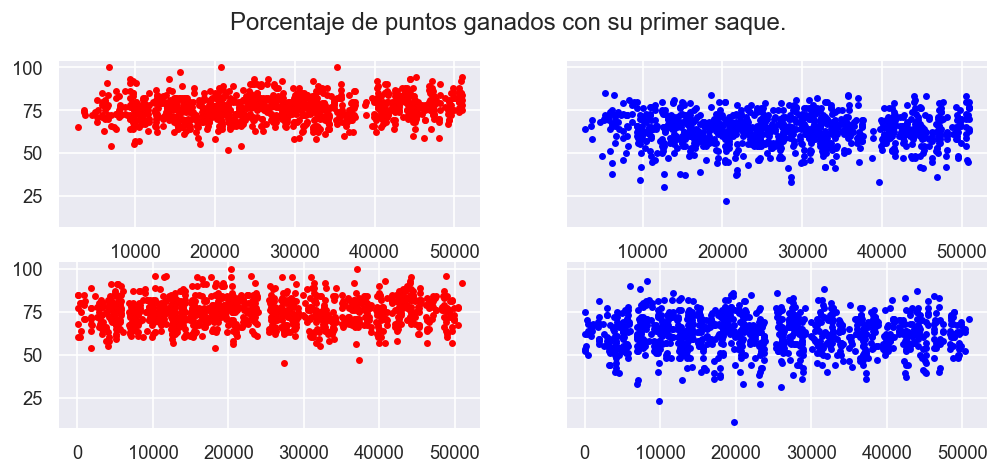

In [74]:
fig, ax = plt.subplots(2,2,sharex=False, sharey=True, dpi=120, figsize=(10, 4))


y1 = df_novak_1['w_1servewon_per']
x1 = df_novak_1.index

y2 = df_novak_1['l_1servewon_per']
x2 = df_novak_1.index

y3 = df_nadal_1['w_1servewon_per']
x3 = df_nadal_1.index

y4 = df_nadal_1['l_1servewon_per']
x4 = df_nadal_1.index

ax[0,0].scatter(x1, y1, color='red', s=10)
ax[0,1].scatter(x2, y2, color='blue', s=10)

ax[1,0].scatter(x3, y3, color='red', s=10)
ax[1,1].scatter(x4, y4, color='blue', s=10)

fig.suptitle('Porcentaje de puntos ganados con su primer saque.')

#plt.scatter(x, y)
#plt.xlabel('Partido')
#plt.ylabel('Puntos ganados con el 1° saque')
plt.show()

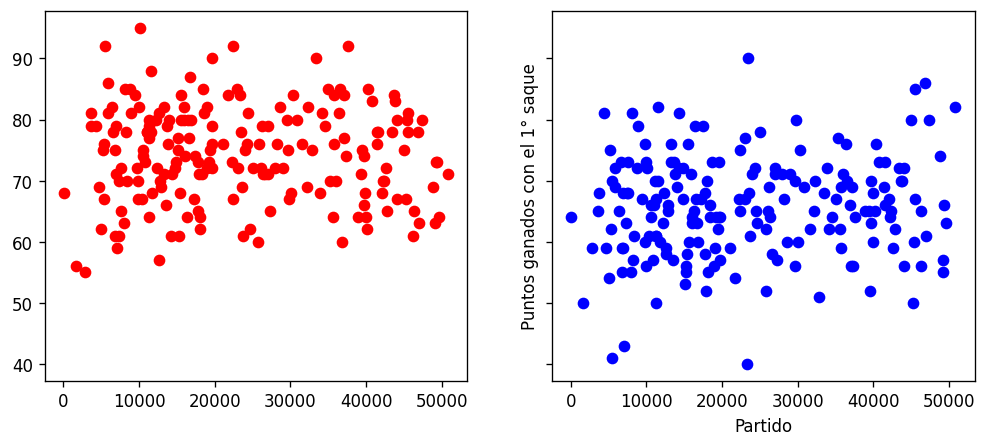

'Cantidad de puntos convertidos con el primer saque.'

In [17]:
fig, ax = plt.subplots(1,2,sharex=True, sharey=True, dpi=120, figsize=(10, 4))

y1 = df_novak_2['w_1servewon_per']
x1 = df_novak_2.index

y2 = df_novak_2['l_1servewon_per']
x2 = df_novak_2.index

ax[0].scatter(x1, y1, color='red')
ax[1].scatter(x2, y2, color='blue')

#plt.scatter(x, y)
plt.xlabel('Partido')
plt.ylabel('Puntos ganados con el 1° saque')
plt.show()
"Cantidad de puntos convertidos con el primer saque."

#### Analizamos las medias y el decil más alto.

In [18]:
df_novak_1['w_1servewon_per'].mean().round(2)

76.06

In [19]:
df_novak_1['l_1servewon_per'].mean().round(2)

63.19

In [20]:
df_novak_1['w_1servewon_per'].quantile(.9)

85.0

In [21]:
df_novak_1['l_1servewon_per'].quantile(.9)

75.0

In [75]:
df_nadal_1['w_1servewon_per'].mean().round(2)

74.69

In [76]:
df_nadal_1['l_1servewon_per'].mean().round(2)

62.19

In [77]:
df_nadal_1['w_1servewon_per'].quantile(.9)

85.0

In [78]:
df_nadal_1['l_1servewon_per'].quantile(.9)

75.0

In [22]:
df_novak_2['w_1servewon_per'].mean().round(2)

74.21

In [23]:
df_novak_2['l_1servewon_per'].mean().round(2)

65.62

In [24]:
df_novak_2['w_1servewon_per'].quantile(.9)

84.0

In [25]:
df_novak_2['l_1servewon_per'].quantile(.9)

76.0

#### El porcentaje de primeros saques es más alto que el de su rivales.

#### En general, está entre 10% a 15% mas alto que el de sus rivales. En algunos casos es mucho mayor. Djokovic genera un gran resultado con sus primeros saques. Incluso, su media en las victorias es ligeramente mas alto que el decil más alto de sus rivales.

####  Es un claro indicador de que influye en las victorias.

## Superficies.

#### Determinamos en las superficies donde mayor cantidad de victorias ha conseguido.

#### Si bien la mayoría de los torneos se juegan en superficie dura, hay jugadores donde se destacan mejor en arcilla o césped.

#### Una superficie favorable para el jugador, da una ventaja importante.

#### Se descarta la superficie Carpet porque, desde 2009, no se usa.

surface
Hard      635
Clay      248
Grass     109
Carpet      6
Name: count, dtype: int64


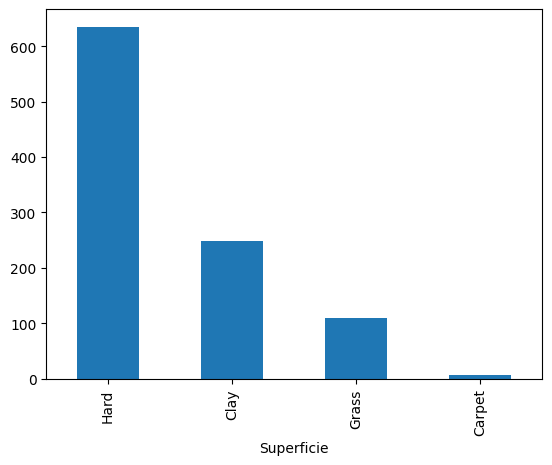

In [26]:
counts = df_novak_1['surface'].value_counts()
print(counts)
counts.plot.bar()
plt.xlabel('Superficie')
plt.show()

surface
Clay     80
Grass    86
Hard     84
Name: count, dtype: int32


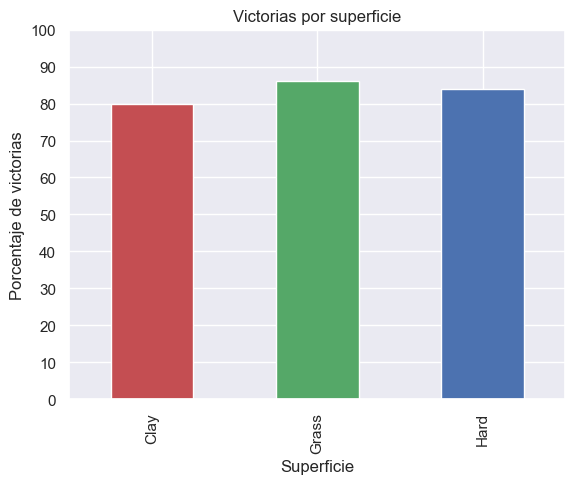

In [82]:
counts_vic_1 = df_novak_1['surface'].value_counts()
counts_der_1 = df_novak_2['surface'].value_counts()

dict_colors = {'Clay': 'r', 'Grass':'g', 'Hard':'b'}
suma_count_1 = counts_vic_1 + counts_der_1
por_victories_sup_1 = (((counts_vic_1/suma_count_1)*100).astype(int))
por_victories_sup_1 = por_victories_sup_1.drop('Carpet')
print(por_victories_sup_1.sort_index())

lista_ticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

por_victories_sup_1.sort_index().plot.bar(x=list(dict_colors.keys()), color=dict_colors.values())

plt.xlabel('Superficie')
plt.ylabel('Porcentaje de victorias')
plt.title('Victorias por superficie')
plt.yticks(lista_ticks)
plt.show()

surface
Clay     92
Grass    79
Hard     78
Name: count, dtype: int32


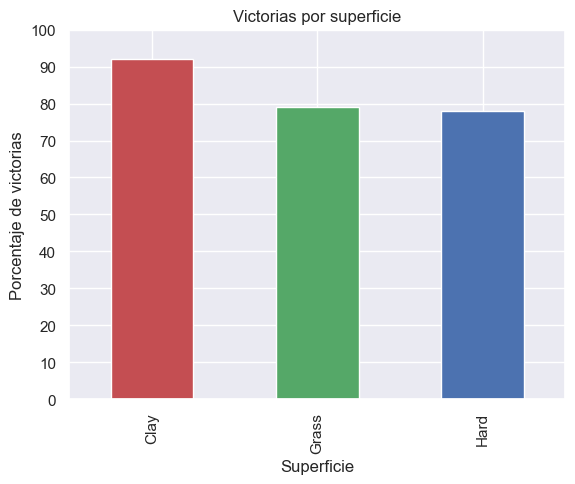

In [81]:
counts_vic_1 = df_nadal_1['surface'].value_counts()
counts_der_1 = df_nadal_2['surface'].value_counts()

dict_colors = {'Clay': 'r', 'Grass':'g', 'Hard':'b'}
suma_count_1 = counts_vic_1 + counts_der_1
por_victories_sup_1 = (((counts_vic_1/suma_count_1)*100).astype(int))
por_victories_sup_1 = por_victories_sup_1.drop('Carpet')
print(por_victories_sup_1.sort_index())

lista_ticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

por_victories_sup_1.sort_index().plot.bar(x=list(dict_colors.keys()), color=dict_colors.values())

plt.xlabel('Superficie')
plt.ylabel('Porcentaje de victorias')
plt.title('Victorias por superficie')
plt.yticks(lista_ticks)
plt.show()

#### La mayor cantidad de victorias se da en césped.

#### Sin embargo, el porcentaje de victorias es similar a las demás superficies. Destaca bien en todas.

## Aces.

#### Otra variable a tener en cuenta es la cantidad de aces. En algunos jugadores, es algo determinante ya que pueden definir su estilo de juego.

#### No suele ser algo tan determinante ya que, hay mucho riesgo involucrado por fallar el primero y asegurar el segundo saque.

<Axes: xlabel='l_ace', ylabel='Count'>

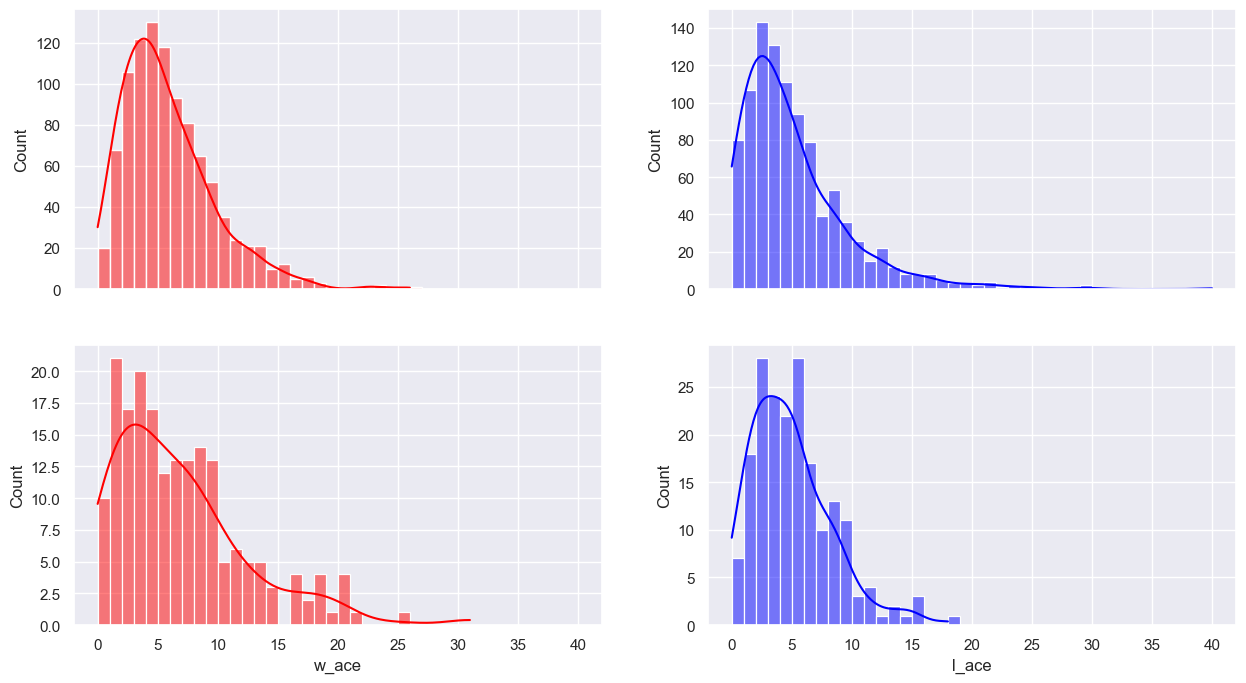

In [28]:
sns.set()
fig, axes = plt.subplots(2, 2, sharex=True,figsize=(15, 8))
sns.histplot(data=df_novak_1, x="w_ace", bins=30, kde=True, binrange=[0,30], color='red', ax=axes[0,0])
sns.histplot(data=df_novak_1, x="l_ace", bins=30, kde=True, binrange=[0,30], color='blue',ax=axes[0,1])
sns.histplot(data=df_novak_2, x="w_ace", bins=30, kde=True, binrange=[0,30], color='red', ax=axes[1,0])
sns.histplot(data=df_novak_2, x="l_ace", bins=30, kde=True, binrange=[0,30], color='blue',ax=axes[1,1])

<Axes: xlabel='l_ace', ylabel='Count'>

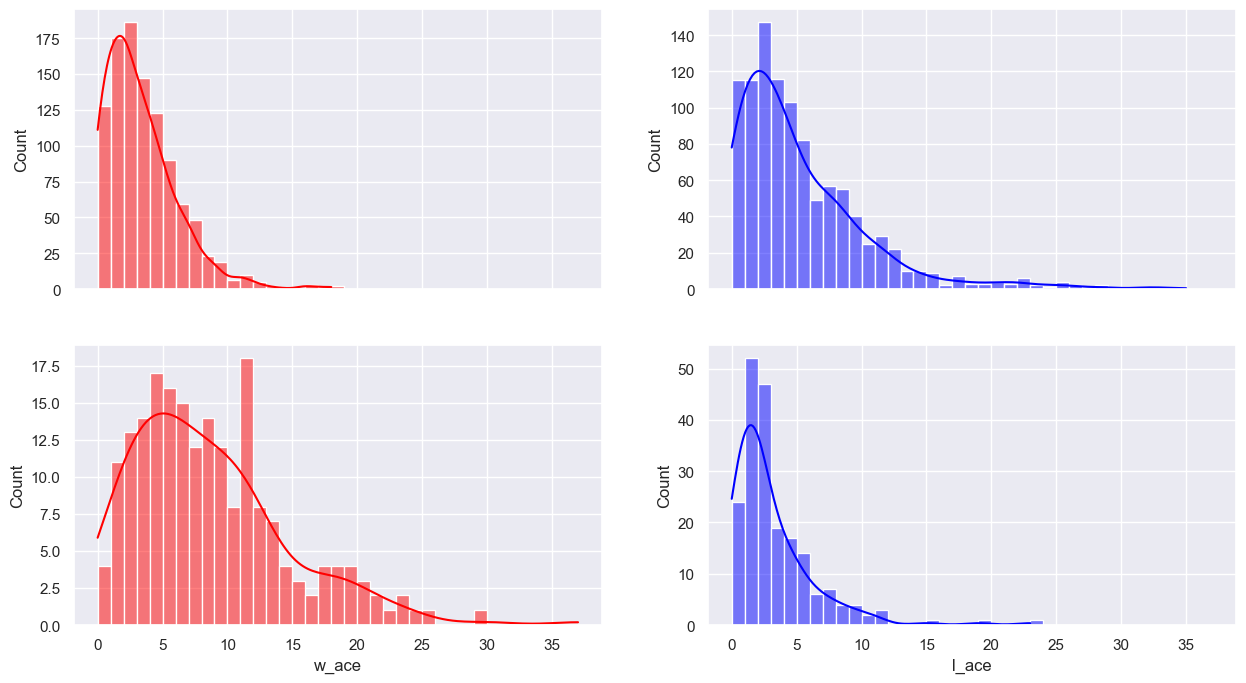

In [86]:
sns.set()
fig, axes = plt.subplots(2, 2, sharex=True,figsize=(15, 8))
sns.histplot(data=df_nadal_1, x="w_ace", bins=30, kde=True, binrange=[0,30], color='red', ax=axes[0,0])
sns.histplot(data=df_nadal_1, x="l_ace", bins=30, kde=True, binrange=[0,30], color='blue',ax=axes[0,1])
sns.histplot(data=df_nadal_2, x="w_ace", bins=30, kde=True, binrange=[0,30], color='red', ax=axes[1,0])
sns.histplot(data=df_nadal_2, x="l_ace", bins=30, kde=True, binrange=[0,30], color='blue',ax=axes[1,1])

#### Analizamos la media y el decil mas alto.

In [29]:
math.ceil(df_novak_1['w_ace'].mean())

6

In [30]:
math.ceil(df_novak_1['l_ace'].mean())

5

In [31]:
math.ceil(df_novak_1['w_ace'].quantile(.9))

11

In [32]:
math.ceil(df_novak_1['l_ace'].quantile(.9))

10

In [87]:
math.ceil(df_nadal_1['w_ace'].mean())

4

In [88]:
math.ceil(df_nadal_1['l_ace'].mean())

6

In [89]:
math.ceil(df_nadal_1['w_ace'].quantile(.9))

7

In [90]:
math.ceil(df_nadal_1['l_ace'].quantile(.9))

11

In [33]:
math.ceil(df_novak_2['w_ace'].mean())

7

In [34]:
math.ceil(df_novak_2['l_ace'].mean())

5

In [35]:
math.ceil(df_novak_2['w_ace'].quantile(.9))

14

In [36]:
math.ceil(df_novak_2['l_ace'].quantile(.9))

9

#### La cantidad de aces es ligeramente superior a la de sus rivales. No parece influir mucho en la victoria.

#### Sin embargo, hace una pequeña diferencia durante el juego.

### Doble faltas.

#### Son puntos que ceden a su rival cuando fallan con su saque.

<Axes: xlabel='l_df', ylabel='Count'>

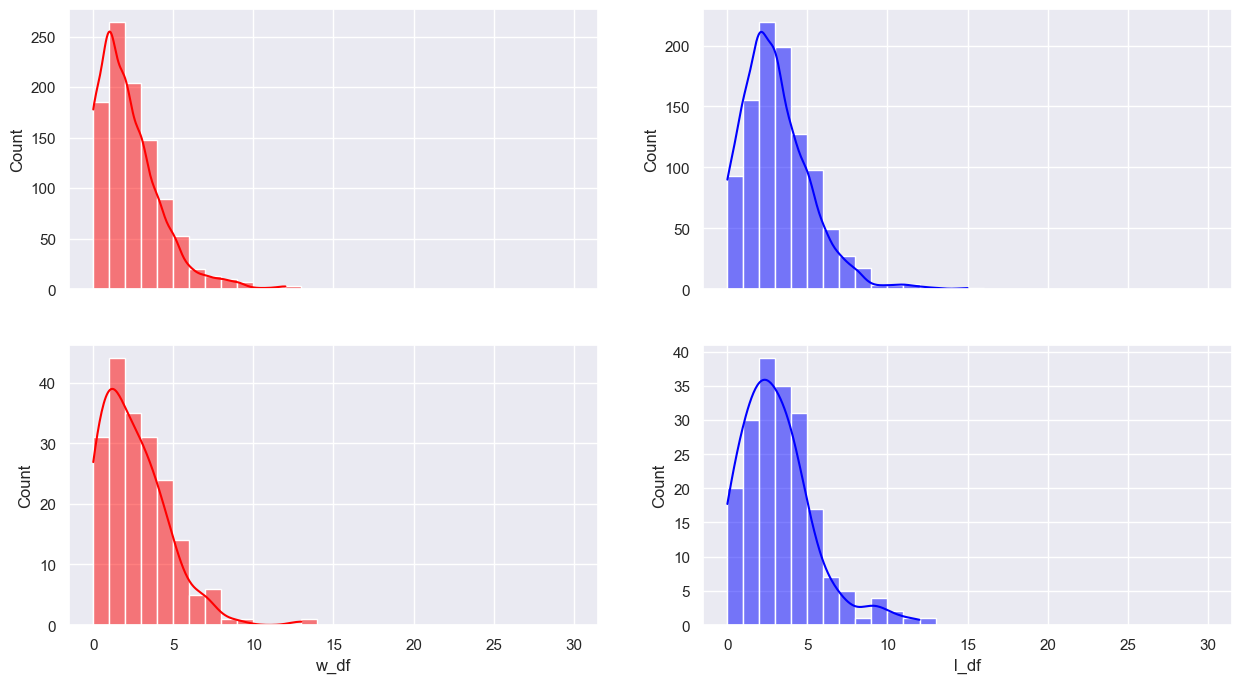

In [37]:
sns.set()
fig, axes = plt.subplots(2, 2, sharex=True,figsize=(15, 8))
sns.histplot(data=df_novak_1, x="w_df", bins=30, kde=True, binrange=[0,30], color='red', ax=axes[0,0])
sns.histplot(data=df_novak_1, x="l_df", bins=30, kde=True, binrange=[0,30], color='blue',ax=axes[0,1])
sns.histplot(data=df_novak_2, x="w_df", bins=30, kde=True, binrange=[0,30], color='red', ax=axes[1,0])
sns.histplot(data=df_novak_2, x="l_df", bins=30, kde=True, binrange=[0,30], color='blue',ax=axes[1,1])

<Axes: xlabel='l_df', ylabel='Count'>

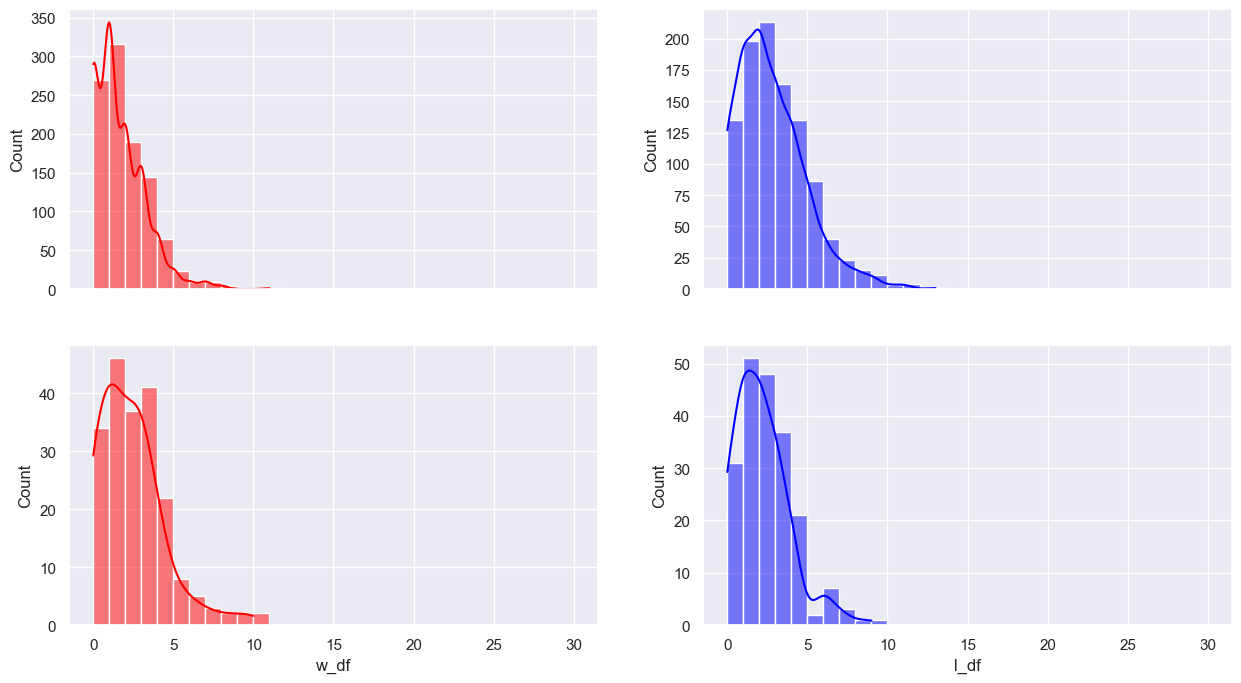

In [91]:
sns.set()
fig, axes = plt.subplots(2, 2, sharex=True,figsize=(15, 8))
sns.histplot(data=df_nadal_1, x="w_df", bins=30, kde=True, binrange=[0,30], color='red', ax=axes[0,0])
sns.histplot(data=df_nadal_1, x="l_df", bins=30, kde=True, binrange=[0,30], color='blue',ax=axes[0,1])
sns.histplot(data=df_nadal_2, x="w_df", bins=30, kde=True, binrange=[0,30], color='red', ax=axes[1,0])
sns.histplot(data=df_nadal_2, x="l_df", bins=30, kde=True, binrange=[0,30], color='blue',ax=axes[1,1])

#### Cede muy pocos puntos por doble falta en las victorias.

#### Cede varios puntos por doble falta en las derrotas.

## Break points.

#### Break points son aquellos puntos decisivos que se ganan contra el saque del rival.  Esto es un indicador de un jugador que juega muy bien cuando recibe el saque de rival y es capaz de ganarle games sin su saque.  Conseguir break points es fundamental para romper el ciclo normal del set.Es un factor muy importante. También, no recibir break points en contra.  

In [38]:
df_novak_1['break_points_made'] = (df_novak_1['l_bpFaced']-df_novak_1['l_bpSaved']).astype(int)
df_novak_1['break_points_recieved'] = (df_novak_1['w_bpFaced']-df_novak_1['w_bpSaved']).astype(int)
df_novak_2['break_points_made'] = (df_novak_2['l_bpFaced']-df_novak_2['l_bpSaved']).astype(int)
df_novak_2['break_points_recieved'] = (df_novak_2['w_bpFaced']-df_novak_2['w_bpSaved']).astype(int)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_21668\2690576739.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_novak_1['break_points_made'] = (df_novak_1['l_bpFaced']-df_novak_1['l_bpSaved']).astype(int)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_21668\2690576739.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_novak_1['break_points_recieved'] = (df_novak_1['w_bpFaced']-df_novak_1['w_bpSaved']).astype(int)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_21668\2690576739.py:3: SettingWithCopyWa

In [39]:
df_novak_1.sample(10)

,Unnamed: 0,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,target,w_1serve_per,w_1servewon_per,l_1servewon_per,break_points_made,break_points_recieved
32836,169469,2015-352,Paris Masters,Hard,48,M,20151102,41,104925,1,0,Novak Djokovic,R,188,SRB,28,104607,5,0,Tomas Berdych,R,196,CZE,30,7-6(3) 7-6(8),3,QF,0,6,2,83,64,51,10,12,1,1,8,1,86,51,41,15,12,1,1,1,15785,5,4730,1,77,79,80,0,0
23970,159546,2012-540,Wimbledon,Grass,128,G,20120625,97,104925,1,0,Novak Djokovic,R,188,SRB,25,103285,28,0,Radek Stepanek,R,185,CZE,33,4-6 6-2 6-2 6-2,5,R32,169,12,1,96,63,50,20,17,4,5,8,1,143,94,57,19,17,14,20,1,12280,27,1340,1,65,79,60,6,1
43443,180197,2019-M024,Cincinnati Masters,Hard,64,M,20190812,297,104925,1,0,Novak Djokovic,R,188,SRB,32,106298,0,0,Lucas Pouille,R,185,FRA,25,7-6(2) 6-1,3,QF,86,5,6,63,45,40,7,10,3,3,2,5,62,37,24,12,9,2,4,1,12325,31,1340,1,71,88,64,2,0
17395,152050,2010-407,Rotterdam,Hard,32,A,20100208,1,104925,1,0,Novak Djokovic,R,188,SRB,22,104660,0,0,Sergiy Stakhovsky,R,193,UKR,24,6-2 4-1 RET,3,R32,54,2,1,31,17,15,10,6,1,1,3,0,52,35,20,6,7,7,11,2,8310,69,663,1,54,88,57,4,0
37469,174156,2017-M016,Eastbourne,Grass,32,A,20170626,300,104925,1,0,Novak Djokovic,R,188,SRB,30,104792,2,0,Gael Monfils,R,193,FRA,30,6-3 6-4,3,F,76,1,1,58,42,32,8,9,3,3,6,1,63,45,30,7,10,3,6,4,5805,16,2545,1,72,76,66,3,0
45511,182365,2020-0605,Tour Finals,Hard,8,F,20201116,295,104925,1,0,Novak Djokovic,R,188,SRB,33,106043,8,0,Diego Schwartzman,R,170,ARG,28,6-3 6-2,3,RR,78,7,2,47,30,23,11,9,1,2,1,1,52,32,20,7,8,2,6,1,11830,9,3455,1,63,76,62,4,1
48094,185074,2021-9512,Belgrade 2,Clay,32,A,20210524,293,104925,1,0,Novak Djokovic,R,188,SRB,34,121531,0,LL,Mats Moraing,L,198,GER,28,6-2 7-6(4),3,R16,100,6,3,70,41,29,16,10,3,5,3,1,72,36,22,14,10,6,10,1,11063,253,241,1,58,70,61,4,2
28921,165143,2014-520,Roland Garros,Clay,128,G,20140526,64,104925,2,0,Novak Djokovic,R,188,SRB,27,105311,0,0,Joao Sousa,R,185,POR,25,6-1 6-2 6-4,5,R128,110,9,3,83,58,38,14,13,7,10,0,2,87,52,32,8,12,7,15,2,11850,44,1039,1,69,65,61,8,3
4620,137469,2005-439,Umag,Clay,32,A,20050725,14,104925,0,0,Novak Djokovic,R,188,SRB,18,102231,0,0,Alex Calatrava,R,190,ESP,32,6-1 6-4,3,R32,63,1,0,52,36,26,13,9,4,4,1,1,41,25,17,7,8,1,4,97,417,163,259,1,69,72,68,3,0
27028,162932,2013-422,Cincinnati Masters,Hard,56,M,20130811,25,104925,1,0,Novak Djokovic,R,188,SRB,26,104338,0,0,Juan Monaco,R,185,ARG,29,7-5 6-2,3,R32,78,5,2,51,30,22,14,10,0,2,2,2,60,35,20,10,10,3,8,1,11400,32,1240,1,58,73,57,5,2


Text(0, 0.5, 'Frecuencia')

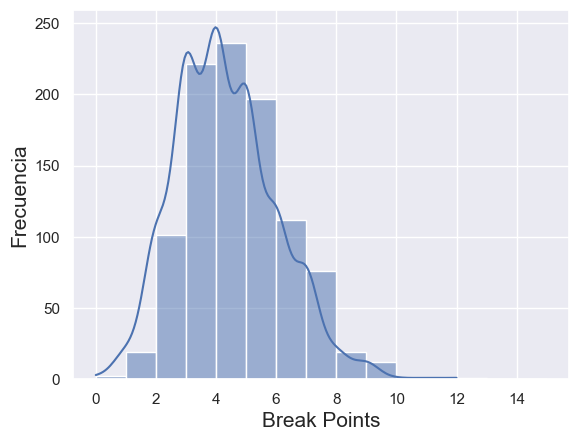

In [40]:
chart = sns.histplot(data=df_novak_1, x="break_points_made", bins=15, kde=True, binrange=[0,15])
chart.set_xlabel('Break Points', fontdict={'size': 15})
chart.set_ylabel('Frecuencia', fontdict={'size': 15})

Text(0, 0.5, 'Frecuencia')

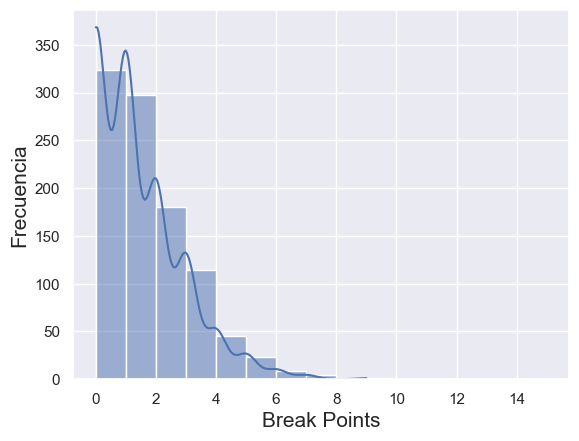

In [41]:
chart = sns.histplot(data=df_novak_1, x="break_points_recieved", bins=15, kde=True, binrange=[0,15])
chart.set_xlabel('Break Points', fontdict={'size': 15})
chart.set_ylabel('Frecuencia', fontdict={'size': 15})

In [92]:
df_nadal_1['break_points_made'] = (df_nadal_1['l_bpFaced']-df_nadal_1['l_bpSaved']).astype(int)
df_nadal_1['break_points_recieved'] = (df_nadal_1['w_bpFaced']-df_nadal_1['w_bpSaved']).astype(int)
df_nadal_2['break_points_made'] = (df_nadal_2['l_bpFaced']-df_nadal_2['l_bpSaved']).astype(int)
df_nadal_2['break_points_recieved'] = (df_nadal_2['w_bpFaced']-df_nadal_2['w_bpSaved']).astype(int)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_21668\4170976710.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nadal_1['break_points_made'] = (df_nadal_1['l_bpFaced']-df_nadal_1['l_bpSaved']).astype(int)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_21668\4170976710.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nadal_1['break_points_recieved'] = (df_nadal_1['w_bpFaced']-df_nadal_1['w_bpSaved']).astype(int)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_21668\4170976710.py:3: SettingWithCopyWa

Text(0, 0.5, 'Frecuencia')

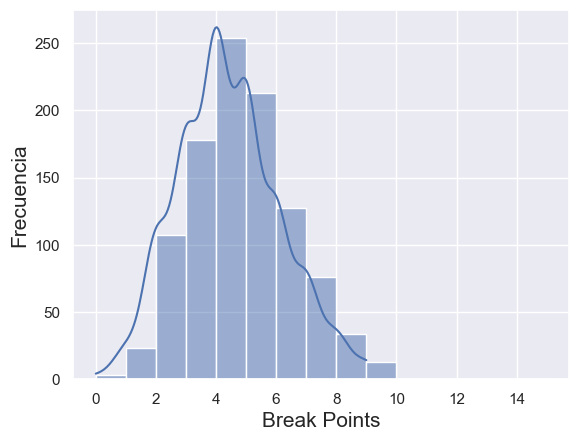

In [93]:
chart = sns.histplot(data=df_nadal_1, x="break_points_made", bins=15, kde=True, binrange=[0,15])
chart.set_xlabel('Break Points', fontdict={'size': 15})
chart.set_ylabel('Frecuencia', fontdict={'size': 15})

Text(0, 0.5, 'Frecuencia')

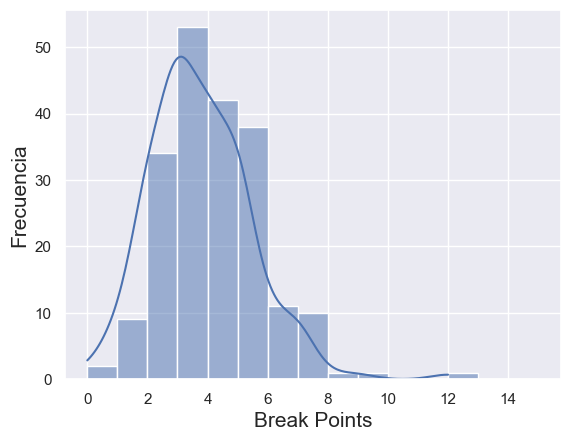

In [94]:
chart = sns.histplot(data=df_nadal_2, x="break_points_made", bins=15, kde=True, binrange=[0,15])
chart.set_xlabel('Break Points', fontdict={'size': 15})
chart.set_ylabel('Frecuencia', fontdict={'size': 15})

#### Analizamos las medias y el decil más alto.

In [42]:
math.ceil(df_novak_1['break_points_made'].mean())

5

In [43]:
math.ceil(df_novak_1['break_points_recieved'].mean())

2

In [44]:
math.ceil(df_novak_1['break_points_made'].quantile(.9))

7

In [45]:
math.ceil(df_novak_1['break_points_recieved'].quantile(.9))

3

In [46]:
math.ceil(df_novak_2['break_points_made'].mean())

4

In [47]:
math.ceil(df_novak_2['break_points_recieved'].mean())

2

In [48]:
math.ceil(df_novak_2['break_points_made'].quantile(.9))

6

In [49]:
math.ceil(df_novak_2['break_points_recieved'].quantile(.9))

4

#### Juntamos las victorias y las derrotas con la data enriquecida y con la cplumna target incluida. 
#### Victoria = 1 , Derrota = 0

In [50]:
df_novak = pd.concat([df_novak_1, df_novak_2], ignore_index=False).drop(['Unnamed: 0','tourney_id','tourney_name', 'draw_size','tourney_date','tourney_level','match_num','winner_id','winner_seed','winner_entry','winner_ht','winner_ioc','winner_hand','winner_age','winner_rank','winner_rank_points','loser_id','loser_seed','loser_entry','loser_ht','loser_ioc','loser_hand','loser_age','loser_rank','loser_rank_points','minutes','surface','winner_name','loser_name','score','best_of','round'], axis=1)

In [51]:
df_novak.sample(10)

,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,target,w_1serve_per,w_1servewon_per,l_1servewon_per,break_points_made,break_points_recieved
15382,3,6,100,50,32,28,14,8,11,6,3,81,40,29,17,14,3,8,1,50,64,72,5,3
29777,13,0,57,43,38,8,11,1,1,2,9,77,39,23,12,11,5,12,1,75,88,58,7,0
13253,8,3,107,60,43,32,15,6,6,5,3,81,52,40,14,14,2,5,0,56,71,76,3,0
13478,3,2,68,45,36,15,12,0,0,6,2,69,46,26,6,11,4,10,1,66,80,56,6,0
21913,7,1,127,84,55,19,19,8,14,2,3,141,96,50,19,18,15,27,1,66,65,52,12,6
33767,2,1,61,39,27,14,9,2,3,0,5,65,42,27,6,9,6,10,1,63,69,64,4,1
24612,4,0,68,45,30,13,11,4,6,5,3,57,23,15,12,10,1,5,1,66,66,65,4,2
28788,2,0,58,39,26,12,11,2,5,4,7,79,49,32,8,10,6,11,1,67,66,65,5,3
17901,2,4,68,42,25,15,9,7,9,2,5,61,31,17,10,8,6,11,1,61,59,54,5,2
40444,18,2,104,77,63,15,19,4,5,11,4,135,81,53,27,18,13,17,1,74,81,65,4,1


In [52]:
df_novak.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1191 entries, 2770 to 50850
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   w_ace                  1191 non-null   int64
 1   w_df                   1191 non-null   int64
 2   w_svpt                 1191 non-null   int64
 3   w_1stIn                1191 non-null   int64
 4   w_1stWon               1191 non-null   int64
 5   w_2ndWon               1191 non-null   int64
 6   w_SvGms                1191 non-null   int64
 7   w_bpSaved              1191 non-null   int64
 8   w_bpFaced              1191 non-null   int64
 9   l_ace                  1191 non-null   int64
 10  l_df                   1191 non-null   int64
 11  l_svpt                 1191 non-null   int64
 12  l_1stIn                1191 non-null   int64
 13  l_1stWon               1191 non-null   int64
 14  l_2ndWon               1191 non-null   int64
 15  l_SvGms                1191 non-null   

In [53]:
df_novak.corr()

,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,target,w_1serve_per,w_1servewon_per,l_1servewon_per,break_points_made,break_points_recieved
w_ace,1.000000,0.178688,0.394558,0.405988,0.507571,0.291278,0.451419,0.099566,0.095764,0.313823,0.117393,0.413653,0.398840,0.442968,0.390382,0.448089,0.108347,0.074686,-0.089999,0.078869,0.242103,0.272613,-0.028401,0.051891
w_df,0.178688,1.000000,0.472232,0.394491,0.386995,0.376635,0.417117,0.372535,0.434287,0.197438,0.218873,0.381410,0.334807,0.344805,0.384099,0.414325,0.134708,0.159034,-0.057995,-0.271450,-0.135431,0.165455,0.130530,0.393940
w_svpt,0.394558,0.472232,1.000000,0.968705,0.934299,0.821290,0.946772,0.613711,0.704949,0.484549,0.290021,0.891439,0.853509,0.873578,0.784108,0.940888,0.359608,0.367385,-0.134073,-0.085965,-0.350573,0.365063,0.205206,0.621386
w_1stIn,0.405988,0.394491,0.968705,1.000000,0.969403,0.693544,0.926518,0.577155,0.659227,0.488960,0.274496,0.874938,0.843462,0.860185,0.757205,0.920669,0.358838,0.367119,-0.097338,0.147267,-0.337918,0.349767,0.206071,0.574561
w_1stWon,0.507571,0.386995,0.934299,0.969403,1.000000,0.659154,0.927745,0.487525,0.541070,0.533715,0.266036,0.873539,0.845371,0.877240,0.766478,0.919590,0.346416,0.328694,-0.075274,0.167215,-0.114620,0.394965,0.134490,0.443834
w_2ndWon,0.291278,0.376635,0.821290,0.693544,0.659154,1.000000,0.811241,0.440144,0.502786,0.447262,0.276186,0.754693,0.713961,0.754576,0.681049,0.799771,0.298572,0.281770,-0.128538,-0.456743,-0.298917,0.376352,0.112086,0.438306
w_SvGms,0.451419,0.417117,0.946772,0.926518,0.927745,0.811241,1.000000,0.433235,0.556837,0.523257,0.306862,0.931070,0.889221,0.904574,0.810720,0.987455,0.399787,0.419029,-0.078775,-0.040814,-0.215719,0.363881,0.254687,0.594311
w_bpSaved,0.099566,0.372535,0.613711,0.577155,0.487525,0.440144,0.433235,1.000000,0.941892,0.141927,0.164431,0.399711,0.382933,0.375896,0.332802,0.432385,0.159119,0.199931,-0.119439,-0.119973,-0.433482,0.134375,0.184451,0.468777
w_bpFaced,0.095764,0.434287,0.704949,0.659227,0.541070,0.502786,0.556837,0.941892,1.000000,0.159369,0.206453,0.525744,0.497275,0.468371,0.432748,0.559333,0.234925,0.312917,-0.135621,-0.152561,-0.554921,0.108675,0.316773,0.738257
l_ace,0.313823,0.197438,0.484549,0.488960,0.533715,0.447262,0.523257,0.141927,0.159369,1.000000,0.264141,0.494662,0.473042,0.589820,0.423776,0.522102,0.127466,0.033131,0.009513,0.028740,0.034332,0.509375,-0.170576,0.134084


## Insights

### * La mayor ventaja la saca con los puntos ganados con el primer servicio. Es el facotr más importante de su juego.

### * El porcentaje victorias en las superficies son muy parejos. Rinde muy bien en cualquier superficie.

### * En los aces, no saca mucha ventaja. Sin embargo, es ligeramente superior que sus rivales.

### * En los break points, saca ventaja sobre sus rivales. La diferencia de puntos le garantiza, al menos, un set.

#### Debido a que los resultados de los partidos pueden ser solo victoria o derrota (categorías), uso una regresión logística para determinar el resultado en base a los números del encuentro.

In [54]:
###Fijarse ne el target para esto, 0=victoria, 1=derrota.

In [61]:
X = df_novak
y = df_novak["target"]  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

modelo = RandomForestRegressor(
            n_estimators = 21,
            criterion    = 'mse',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

y_pred

c:\users\usuario\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
c:\users\usuario\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
       0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 0., 1., 1., 1.

In [62]:
predicciones = modelo.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 0.0


c:\users\usuario\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
c:\users\usuario\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\users\usuario\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\users\usuario\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWar

c:\users\usuario\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
c:\users\usuario\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\users\usuario\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
c:\users\usuario\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_forest.py:416

c:\users\usuario\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
c:\users\usuario\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\users\usuario\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
c:\users\usuario\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_forest.py:416

Valor óptimo de n_estimators: 21


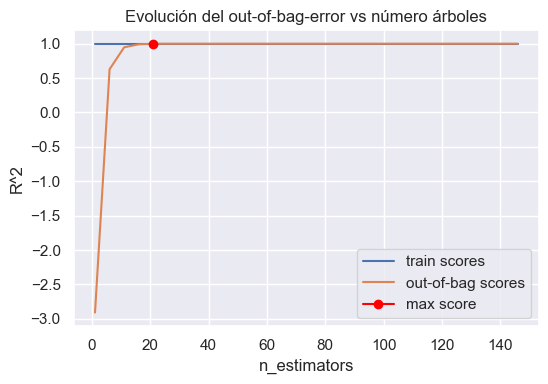

In [60]:
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'mse',
                max_depth    = None,
                max_features = 'auto',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")

#### Usamos una matriz de confusión para ver los resultados de las predicciones y los datos verdaderos.

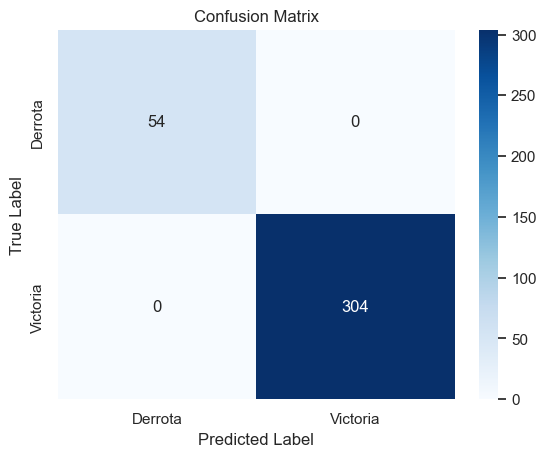

In [63]:
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm, index=["Derrota", "Victoria"], columns=["Derrota", "Victoria"])

fig, ax = plt.subplots()

sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")

ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("Confusion Matrix")
plt.show()

In [64]:
cm = confusion_matrix(y_test, y_pred)

cm

array([[ 54,   0],
       [  0, 304]], dtype=int64)

In [95]:
df_versus = pd.concat([df_novak_1, df_nadal_1], ignore_index=False).drop(['Unnamed: 0','tourney_id','tourney_name', 'draw_size','tourney_date','tourney_level','match_num','winner_id','winner_seed','winner_entry','winner_ht','winner_ioc','winner_hand','winner_age','winner_rank','winner_rank_points','loser_id','loser_seed','loser_entry','loser_ht','loser_ioc','loser_hand','loser_age','loser_rank','loser_rank_points','minutes','surface','winner_name','loser_name','score','best_of','round'], axis=1)

In [97]:
df_versus.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2026 entries, 2770 to 50923
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   w_ace                  2026 non-null   int64  
 1   w_df                   2026 non-null   int64  
 2   w_svpt                 2026 non-null   int64  
 3   w_1stIn                2026 non-null   int64  
 4   w_1stWon               2026 non-null   int64  
 5   w_2ndWon               2026 non-null   int64  
 6   w_SvGms                2026 non-null   int64  
 7   w_bpSaved              2026 non-null   int64  
 8   w_bpFaced              2026 non-null   int64  
 9   l_ace                  2026 non-null   int64  
 10  l_df                   2026 non-null   int64  
 11  l_svpt                 2026 non-null   int64  
 12  l_1stIn                2026 non-null   int64  
 13  l_1stWon               2026 non-null   int64  
 14  l_2ndWon               2026 non-null   int64  
 15  l_SvG